In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/plant-seedlings-classification/"

## Visualize the images. 
Its important to know what dataset we are trainng on

In [ ]:
## Lets get the first image from each folder

fnames = os.listdir(f"{PATH}train") #names of the folder

def getFirstImage(directoryName):
    return [glob(f"{PATH}train/{f}/*.png")[0] for f in fnames]


In [ ]:
lst_images = getFirstImage(fnames)
lst_images

### First image from all the categrory is plotted

In [ ]:
plots_from_files(lst_images, titles=fnames, 
                 maintitle= "Seedlings", figsize=(10,8),
                 rows = 4)

In [ ]:
#Creating a valid directory and placing 20% of the 
#images from each directory inside the valid 

if not os.path.exists(f"{PATH}valid"):
    os.makedirs(f"{PATH}valid")
    shutil.rmtree(f"{PATH}valid")
    for name in fnames:
        os.makedirs(f"{PATH}valid/{name}", exist_ok=True)
else:
    shutil.rmtree(f"{PATH}valid")
    for name in fnames:
        os.makedirs(f"{PATH}valid/{name}", exist_ok=True)
#print the result
os.listdir(f"{PATH}valid")

In [ ]:
## #Lets check the #of files for each plant type 
[(f, len(glob(f"{PATH}train/{f}/*")), len(glob(f"{PATH}valid/{f}/*"))) for f in fnames] 

In [ ]:
# Move 20% of the images from each folder in train to the same name folder in valid directory
for dir in glob(f"{PATH}/train/*"):
    lst_imgs = glob(f"{dir}/*")
    dirName  = dir.split("\\")[1]
    lst_imgs = list(np.random.choice(lst_imgs, int(0.02*len(lst_imgs)), replace=False))
    [shutil.move(f, f"{PATH}valid/{dirName}") for f in lst_imgs]

### Images inside each folder for train and valid

In [ ]:
#Lets check the #of files for each plant type

[(f, len(glob(f"{PATH}train/{f}/*")), len(glob(f"{PATH}valid/{f}/*"))) for f in fnames] 

As you can see the images within `Common Chickwee` and `Loose Silky-bent` are a lot more than that of `Shepherd’s Purse'`. But for the start, I do not focus on _balancing_ the dataset. I try with the dataset, as it is..

In [ ]:
## Check the size of the images by taking a random directory.
dirname = random.sample(fnames, 1)
print ("The directory {} is selected".format(dirname[0]))
## Check the size of the images by taking a random directory, lets say "Charlock"
a = [plt.imread(img).shape for img in glob(f"{PATH}train/{dirname[0]}/*.png")]

In [ ]:
# The histogram of x 
plt.hist([x[0] for x in a])

There are many images whose dimnesions are quite _large_, and they need **resizing**. 

In [ ]:
# The histogram of y
plt.hist([y[1] for y in a])

## 0. Resizing the dataset 

## 1. Train the model

In [4]:
#sz= 224
arch=resnet50
bs=64

In [ ]:
?ImageClassifierData.from_paths

In [5]:
def get_data(sz, bs):
    tfms  = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data  = ImageClassifierData.from_paths(PATH, tfms=tfms, 
                                           test_name="test", 
                                           num_workers=8)
    return data 

In [6]:
sz=64
data = get_data(sz, 64)
data = data.resize(int(sz*1.3), 'tmp')

In [7]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 64/73 [00:04<00:00, 14.07it/s, loss=10.8]


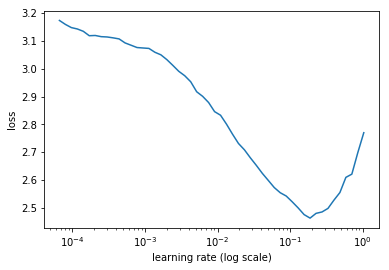

In [8]:
lrf=learn.lr_find()
learn.sched.plot()

In [9]:
lr = 0.1
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                                                                   
    0      2.20218    1.383497   0.550562  
    1      1.640722   1.191332   0.573034                                                                                                                   
    2      1.479842   1.134507   0.573034                                                                                                                   
    3      1.289001   1.010967   0.651685                                                                                                                   
    4      1.180174   0.960908   0.662921                                                                                                                   
    5      1.115166   0.938451   0.640449                                                                                                                   
    6      1.1

[array([0.89404]), 0.6516854012950083]

In [10]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                                                                   
    0      1.058793   0.623742   0.808989  
    1      0.808049   0.52444    0.786517                                                                                                                   
    2      0.557559   0.361347   0.898876                                                                                                                   
    3      0.545405   0.404418   0.853933                                                                                                                   
    4      0.473675   0.285253   0.898876                                                                                                                   
    5      0.368416   0.289867   0.88764                                                                                                                    
    6      0.2

[array([0.27825]), 0.9101123535231258]

In [11]:
sz=128

In [12]:
learn.set_data(get_data(sz, 64))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                                                                   
    0      0.958936   0.879239   0.707865  
    1      0.895548   0.805695   0.730337                                                                                                                   
    2      0.823824   0.715061   0.752809                                                                                                                   
    3      0.831462   0.742646   0.741573                                                                                                                   
    4      0.808975   0.76956    0.730337                                                                                                                   
    5      0.7661     0.659921   0.775281                                                                                                                   
    6      0.7

[array([0.65569]), 0.764044951856806]

In [13]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                                                                   
    0      0.417819   0.281705   0.898876  
    1      0.354944   0.328076   0.865169                                                                                                                   
    2      0.259698   0.227294   0.910112                                                                                                                   
    3      0.294544   0.302144   0.88764                                                                                                                    
    4      0.264827   0.274421   0.898876                                                                                                                   
    5      0.190908   0.250122   0.921348                                                                                                                   
    6      0.1

[array([0.21864]), 0.9325842636354854]

In [14]:
sz=256
learn.set_data(get_data(sz, 64))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                                                                   
    0      0.382366   0.365189   0.853933  
    1      0.359041   0.359139   0.88764                                                                                                                    
    2      0.295187   0.311788   0.876404                                                                                                                   
    3      0.310919   0.304176   0.865169                                                                                                                   
    4      0.288879   0.333653   0.853933                                                                                                                   
    5      0.256302   0.265438   0.88764                                                                                                                    
    6      0.2

[array([0.26814]), 0.8876404541262081]

In [15]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                                                                   
    0      0.354995   0.213538   0.910112  
    1      0.2921     0.290896   0.876404                                                                                                                   
    2      0.199672   0.144241   0.94382                                                                                                                    
    3      0.202399   0.238806   0.898876                                                                                                                   
    4      0.185238   0.211388   0.932584                                                                                                                   
    5      0.135782   0.129094   0.932584                                                                                                                   
    6      0.1

[array([0.11259]), 0.9550561737478449]

In [16]:
sz=299
learn.set_data(get_data(sz, 64))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                                                                   
    0      0.108897   0.11921    0.94382   
    1      0.105914   0.112105   0.955056                                                                                                                   
    2      0.098919   0.125226   0.921348                                                                                                                   
    3      0.104729   0.116629   0.955056                                                                                                                   
    4      0.106636   0.119106   0.921348                                                                                                                   
    5      0.093803   0.118635   0.955056                                                                                                                   
    6      0.0

[array([0.11074]), 0.9438202186916651]

In [17]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

  0%|                                                                                                                                | 0/73 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

In [ ]:
learn.save(f'{sz}')

In [18]:
multi_preds, y = learn.TTA(is_test=True)

RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

In [ ]:
preds = np.mean(multi_preds, 0)

In [ ]:
pred_exp = np.exp(preds)

In [ ]:
pred_exp.shape

In [ ]:
pred_exp

In [ ]:
data.classes

In [ ]:
results = np.argmax(pred_exp, axis=1)

In [ ]:
results[0:10]

In [ ]:
category = []
for result in results:
    category.append(data.classes[result])

In [ ]:
category[0:10]

In [ ]:
data.test_dl.dataset.fnames[0]

In [ ]:
filenames = [f[5:] for f in data.test_dl.dataset.fnames]

In [ ]:
filenames[0:10]

In [ ]:
final = pd.DataFrame({"file": filenames, "species": category })

In [ ]:
final.head()

In [ ]:
??final.to_csv

In [ ]:
final.to_csv("submit.csv", index=False)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('submit.csv')